#**MAFAT Radar Challenge - Baseline Model**

In this notebook, a Convolutional Neural Network (CNN) baseline model is presented. 

The model is trained on the training and auxiliary datasets.   
In the end, a submission file with predictions for the public test set is being created and downloaded.

The raw input for the model is the segments I/Q matrices.   
Note that this is a simplistic baseline model. The model should only be used as a boilerplate code to boost development and to accelerate participants' orientation phase. Participants are encouraged to explore different, more creative, approaches, such as data augmentation, unsupervised pre-training/autoencoders, RNNs/transformers, signal processing, feature engineering, transfer learning, etc.   
   
To learn more about signals, I/Q, Doppler and other terms please go to [Resources](https://competitions.codalab.org/competitions/25389#learn_the_details-resources) on the competition website.    
Please read the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing) to get familiar with the data.
   
Submissions are evaluated on the area under the Receiver Operating Characteristic Curve ([ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)).   
**The baseline model final result on the public test set is:   
 0.73 ROC AUC.**

[Competition website](https://competitions.codalab.org/competitions/25389)   
[MAFAT Challenge homepage](https://mafatchallenge.mod.gov.il/)

## **Setup**

In [1]:
!pip install tensorflow-determinism

In [2]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
cd "/content/gdrive/My Drive/WORK/ML/develop/MAFAT"

/content/gdrive/My Drive/WORK/ML/develop/MAFAT


# How to connect to github using ssh

[https://medium.com/@ashkanpakzad/data-into-google-colab-5ddeb4f4e8](https://medium.com/@ashkanpakzad/data-into-google-colab-5ddeb4f4e8)


---

Following commands should be executed only once for setup in order to connect to private github repo:

```
!ssh-keygen -t rsa -b 4096 -C “hershkoy@github.com”

#this is the private key. copy paste and *SAVE IT* on your local disk for any future use 
!cat /root/.ssh/id_rsa.pub

#this is your public key. copy-paste and upload to github (settings => SSH and GPG keys => New key)
!cat /root/.ssh/id_rsa

!ssh-keyscan github.com >> /root/.ssh/known_hosts
!chmod 644 /root/.ssh/known_hosts
!chmod 600 /root/.ssh/id_rsa

```



In [7]:
!rm sota-mafat-radar
!ssh -T git@github.com
!git clone git@github.com:ShaulSolomon/sota-mafat-radar.git

rm: cannot remove 'sota-mafat-radar': No such file or directory
Hi hershkoy! You've successfully authenticated, but GitHub does not provide shell access.
Cloning into 'sota-mafat-radar'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 39 (delta 10), reused 31 (delta 5), pack-reused 0
Receiving objects: 100% (39/39), 656.29 KiB | 1.84 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [8]:
import os
import sys
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

sys.path.insert(0,os.path.join(os.getcwd(),"sota-mafat-radar/code/utils"))

import experiment_utils as utils


# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.2.0'

In [10]:
# Set and test path to competition data files
competition_path = os.path.join(os.getcwd(),"data") 
try:
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**

All functions will be used in the "Training the Model" section.

### **Data loading**

## **Data Preprocessing**
**The preprocessing main steps:**   
1. Applying [DFT](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (Discrete Fourier transform) by using the fast Fourier transform algorithm ([FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) and [Hann function](https://www.mathworks.com/help/signal/ref/hann.html) to smooth the I/Q matrix. Afterward, calculating the absolute value of the I/Q matrix complex numbers.   
More information about Windowing and Hann function:   
[Wikipedia Hann](https://en.wikipedia.org/wiki/Hann_function#:~:text=The%20Hann%20function%20of%20length,can%20be%20even%20or%20odd.)   
[Wikipedia Window function](https://en.wikipedia.org/wiki/Window_function)   
2. Set max value on the center of the target's mass.   
The doppler burst is a vector (1 x 32) that marks the center of the target's mass on each I/Q matrix in every time unit (32 time-units).   
The preprocess sets the maximum value of each I/Q matrix in-place of the values at the center of the target's mass.
3. Normalization - Transforming I/Q matrix values to standardized values.   
Subtraction of the mean and division by the standard deviation.

**Preprocessing main steps explained:**   
The DFT converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa.   
The I/Q matrix in this challenge is being converted from the velocity domain to the frequency domain.
Windows (like "Hann") are used to reduce spectral leakage when performing a Fourier Transform on time data and converting it into the frequency domain.

The purpose of switching the values of the center of the target's mass in the I/Q matrix with the max value of the matrix is to enhance this part of the matrix and focus the model on this part.


Finally, the normalization is used for scaling all the I/Q matrices.

* *Note: the target_type lables are strings ("human" and "animal"), the data_preprocess function replaces them to "human" = 1 and "animal" = 0.*   
   


**The FFT Process Explained:**   
The IQ matrix contains 32 x 128 elements being 128 I/Q time data samples within a single radar processing time frame and 32 consecutive such time units. The X-axis represents the pulse transmission time, also known as “slow-time”. The Y-axis represents the reception time of signals with respect to pulse transmission time divided into 128 equal sized bins, also known as “fast-time”. The reason FFT is performed on the ‘fast time’ axis (i.e. 128 samples) rather than on the ‘slow time’ axis (i.e. 32 samples) is a matter of scale. An underlying assumption for an effective FFT analysis is that ‘acceleration’ during the time frame represented by the data is very low. Given the type of motion presented by humans and animals only the ‘fast time’ axis complies with this assumption.
Therefore, FFT processing should be applied over the dimension of 128 I/Q time samples to get the frequency content of the returned radar signal at each time frame. A spectrogram (as shown in the samples) is generated by attaching together 32 consecutive FFT results (please note that besides FFT processing some additional manipulation is required to properly display a spectrogram – like taking a LOG of the absolute value and passing a threshold – this is well detailed in the ‘Processing’ section of the competition notebook). Therefore, a spectrogram would eventually provide a display of how the frequency content of the returned signal is changing along time.

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments (see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing)),   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced (more animals than humans, see the [Descriptive Statistics notebook](https://colab.research.google.com/drive/11Lzihg2vKIbo4KAIIJxW5CRZIncoWgtL?usp=sharing).   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

## **Model**

### **CNN Model**
The model has two convolutional layers, both followed by max-pooling layers.    
Those layers are followed by 2 fully-connected (dense) layers, activated with a ReLU function and regularized with   
L2 regularization, followed by a final output layer with a single neuron with a Sigmoid activation function,   
used for final binary classification.

In [11]:
# Building the model
def create_model(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model

### **Evaluation and Visualization of Model's results**

## **Training The Model**

In [12]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = utils.load_data(experiment_auxiliary, folder=competition_path )

In [13]:
# Taking sample from the Auxiliary Experiment set
train_aux = utils.aux_split(experiment_auxiliary_df)

In [14]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [15]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = utils.load_data(train_path, folder=competition_path )

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = utils.data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y = utils.split_train_val(train_df)

val_y =  val_y.astype(int)
train_y =train_y.astype(int)
train_x = train_x.reshape(list(train_x.shape)+[1])
val_x = val_x.reshape(list(val_x.shape)+[1])

In [16]:
# Public test set - loading and preprocessing
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = utils.load_data(test_path, folder=competition_path )
test_df = utils.data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
test_x = test_x.reshape(list(test_x.shape)+[1])

In [17]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 10
optimizer = Adam(learning_rate = 0.001)
input_shape = (img_width, img_height, 1)

init = tf.keras.initializers.GlorotNormal(seed = 0)

# Creating and running the model
model = create_model(input_shape, init)  
model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])


**Model Architecture**   
   
![](https://drive.google.com/uc?export=view&id=1wsJBHbghEPGT0s1QQG6BHl7MS3Yo0o4i)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 30, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 6, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               737408    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4

In [19]:
# Model fit
history = model.fit(train_x, train_y, batch_size = batch_size, epochs = no_epochs, 
                    validation_data = (val_x, val_y))

Epoch 1/10
411/411 [==============================] - 3s 7ms/step - loss: 0.4955 - auc: 0.9305 - accuracy: 0.9030 - val_loss: 0.5904 - val_auc: 0.8106 - val_accuracy: 0.7411
Epoch 2/10
411/411 [==============================] - 2s 5ms/step - loss: 0.2345 - auc: 0.9515 - accuracy: 0.9233 - val_loss: 0.5404 - val_auc: 0.8652 - val_accuracy: 0.7508
Epoch 3/10
411/411 [==============================] - 2s 5ms/step - loss: 0.2044 - auc: 0.9630 - accuracy: 0.9356 - val_loss: 0.4598 - val_auc: 0.9008 - val_accuracy: 0.8091
Epoch 4/10
411/411 [==============================] - 2s 5ms/step - loss: 0.1823 - auc: 0.9703 - accuracy: 0.9414 - val_loss: 0.5110 - val_auc: 0.9043 - val_accuracy: 0.7994
Epoch 5/10
411/411 [==============================] - 2s 5ms/step - loss: 0.1685 - auc: 0.9757 - accuracy: 0.9455 - val_loss: 0.4225 - val_auc: 0.9125 - val_accuracy: 0.8220
Epoch 6/10
411/411 [==============================] - 2s 5ms/step - loss: 0.1612 - auc: 0.9764 - accuracy: 0.9499 - val_loss: 0.45

#### **Results**
Submissions are evaluated on the area under the Receiver Operating Characteristic Curve ([ROC AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))   
on the predicted probabilities, as calculated by [roc_auc_score in scikit-learn (v 0.23.1)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).


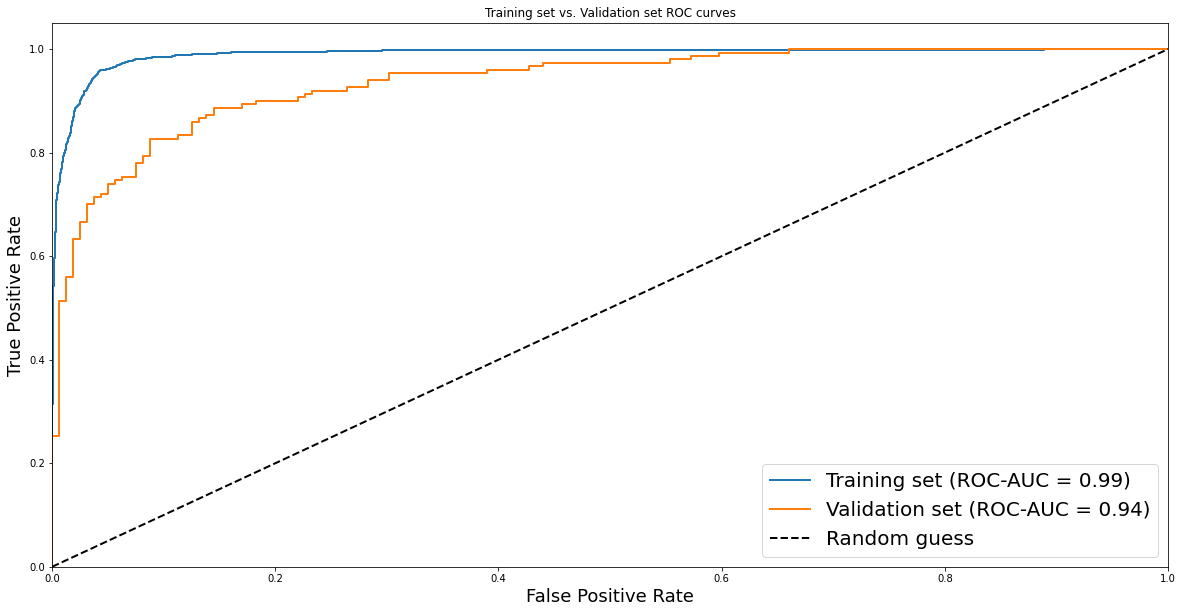

In [20]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [model.predict(train_x), model.predict(val_x)]
actual = [train_y, val_y]
utils.stats(pred, actual)

## **Final Submission File**

Create a CSV submission file , zip and download it.

In [ ]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
# Download zip file
from zipfile import ZipFile
from google.colab import files

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')

files.download('submission.zip')
